This script implements a gradient-based frame interpolation algorithm for fusing event streams with intensity frames

No residual learning is applied

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import datetime, time
from skimage.measure import compare_ssim as ssim
#from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_psnr
from skimage.io import imread
from skimage.io import imsave
import json
import utils.visualization as vs
import utils.events_processing as ep

start time: 0.157 
end time: 0.183
image shape: (2, 180, 240)
# of events: (95234,)
max val of event frames: 20.0
min val of event frames: -17.0


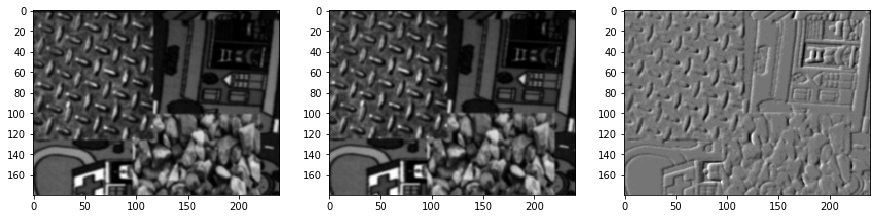

In [13]:
# load data (DAVIS)
davisDir = '/home/winston/data/davis/simulation_3planes'
imgDir = os.path.join(davisDir, 'images')
imgFileList = np.sort(os.listdir(imgDir))
imgPairId = [6, 7]
imgPair = np.array([imread(os.path.join(imgDir,imgFileList[imgPairId[0]]))/255.0, 
                    imread(os.path.join(imgDir,imgFileList[imgPairId[1]]))/255.0])
timeStart, timeEnd = ep.findTimeWindowFromId(os.path.join(davisDir, 'images.txt'), imgFileList, imgPairId)
print("start time:", timeStart, "\nend time:", timeEnd)
print("image shape:", np.shape(imgPair))
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(imgPair[0], cmap = 'gray')
plt.subplot(132)
plt.imshow(imgPair[1], cmap = 'gray')
eventsTime, eventsXYP = ep.loadEventsWithinTimeWindow(os.path.join(davisDir, 'events.txt'), timeStart, timeEnd)

eventFrames = ep.binEventFrames(eventsTime, eventsXYP, 0, 1)
plt.subplot(133)
plt.imshow(eventFrames[0], cmap = 'gray')
print("max val of event frames:", np.max(eventFrames))
print("min val of event frames:", np.min(eventFrames))

In [14]:
# models
def init_hres(config, lres_gt):
    # input lres_gt will be in shape (1, y, x, t)
    lres_mean = np.expand_dims(np.mean(lres_gt, axis = 3), axis = 3)
    lres_mean_var = tf.Variable(lres_mean, dtype = tf.float32)
    lres_gt_var = tf.Variable(lres_gt, dtype = tf.float32)
    # init hres
    if config.shape_mode == 0: # interpolation mode
        if config.init_mode == 0: # hres init as lres-mean-lres
            lres_start = tf.Variable(tf.transpose(tf.gather_nd(tf.transpose(lres_gt_var, perm = [3,0,1,2]), indices = [[0]]), perm = [1,2,3,0]), dtype = tf.float32)
            lres_end = tf.Variable(tf.transpose(tf.gather_nd(tf.transpose(lres_gt_var, perm = [3,0,1,2]), indices = [[1]]), perm = [1,2,3,0]), dtype = tf.float32)

            for i in range(config.hres_dim3):
                if i == 0:
                    hres_init = lres_start
                elif i == config.hres_dim3 - 1:
                    hres_init = tf.concat([hres_init, lres_end], 3)
                else:
                    hres_init = tf.concat([hres_init, lres_mean_var], 3)
            print("hres_tensor initialized (lres-mean-lres), shape:", np.shape(hres_init))
        elif config.init_mode == 1: # hres init as mean+rand
            for i in range(config.hres_dim3):
                lres_rand = lres_mean*(1.0 - config.noise_a) + config.noise_a*(np.random.rand(1, config.dim1, config.dim2, 1)-0.5)
                if i == 0:
                    hres_init = tf.Variable(lres_rand, dtype = tf.float32)
                else:
                    hres_init = tf.concat([hres_init, tf.Variable(lres_rand, dtype = tf.float32)], 3)
            print("hres_tensor initialized (rand), shape:", np.shape(hres_init))
    return hres_init
    
def init_flow(config):
    if config.flow_init == 0:
        flow_x = tf.Variable(tf.zeros(config.hres_dim))
        flow_y = tf.Variable(tf.zeros(config.hres_dim))
        flow = tf.concat([flow_x, flow_y], 0)
        return flow
        
def frame_model(config, hres_tensor):
    if config.shape_mode == 0: #  interpolation
        lres_transpose = tf.gather_nd(tf.transpose(hres_tensor, perm = [3,0,1,2]), indices = [[0],[config.hres_dim3-1]])
        lres_tensor = tf.transpose(lres_transpose, perm = [1,2,3,0])
        print("lres_tensor, shape:", np.shape(lres_tensor))
    return lres_tensor

def event_model(config, hres_tensor):
    hres_ndhwc = tf.nn.relu(tf.expand_dims(hres_tensor, axis = 4))
    tanh_coef = tf.constant(config.tanh_coef)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), axis = 0), axis = 0), axis = 3), axis = 4)
    evf_tanh = tf.tanh(tanh_coef*tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "VALID", data_format = "NDHWC"))
    print("evf_tanh, shape:", np.shape(evf_tanh))
    evf_sum = tf.reduce_sum(evf_tanh, 3, keepdims = True)
    return tf.squeeze(evf_sum, [4])

def tv_2d(config, hres_tensor):
    hres_ndhwc = tf.expand_dims(hres_tensor, axis = 4)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), axis = 1), axis = 2), axis = 3), axis = 4)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), axis = 0), axis = 2), axis = 3), axis = 4)

    dx = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dy = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    return tf.norm(dx+dy, ord = 1)

def tv_t(config, hres_tensor):
    hres_ndhwc = tf.expand_dims(hres_tensor, axis = 4)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), axis = 0), axis = 0), axis = 3), axis = 4)
    dt = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "VALID", data_format = "NDHWC"), [4])
    return tf.norm(dt, ord = 1)

def flow_loss(config, hres_tensor, flow):
    flowx_tensor = tf.slice(flow, [0,0,0,0],[1,-1,-1,-1])
    flowy_tensor = tf.slice(flow, [1,0,0,0],[1,-1,-1,-1])
    hres_ndhwc = tf.expand_dims(hres_tensor, axis = 4)
    flowx_ndhwc = tf.expand_dims(flowx_tensor, axis = 4)
    flowy_ndhwc = tf.expand_dims(flowy_tensor, axis = 4)
    
    flow_coef_xy = tf.constant(config.flow_norm_xy_coef, dtype = tf.float32)
    flow_coef_t = tf.constant(config.flow_norm_t_coef, dtype = tf.float32)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 1), axis = 2), axis = 3), axis = 4)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 0), axis = 2), axis = 3), axis = 4)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis = 0), axis = 0), axis = 3), axis = 4)
    
    dHx = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dHy = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dHt = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    
    flow_eq = tf.multiply(dHx, flowx_tensor) + tf.multiply(dHy, flowy_tensor) + dHt
    
    dUxx = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dUxy = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dUyx = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dUyy = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dUxt = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    dUyt = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    
    return tf.norm(flow_eq, ord = 1) + flow_coef_xy*tf.norm(dUxx+dUxy+dUyx+dUyy, ord = 1)+ flow_coef_t*tf.norm(dUxt+dUyt, ord = 1)


def loss_all(config, ph, hres_tensor, lres_tensor, evf_tensor, flow_tensor):
    # frame_loss = tf.reduce_mean(tf.squared_difference(ph.lres_gt, lres_tensor))
    # event_loss = tf.constant(config.ev_weight)*tf.reduce_mean(tf.squared_difference(ph.evf_gt, evf_tensor))
    frame_loss = tf.norm(ph.lres_gt - lres_tensor, ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - evf_tensor, ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    opt_flow_loss = tf.constant(config.flow_loss_coef)*flow_loss(config, hres_tensor, flow_tensor)
    return frame_loss + event_loss + tv_loss + opt_flow_loss

def loss_no_flow(config, ph, hres_tensor, lres_tensor, evf_tensor):
    frame_loss = tf.norm(ph.lres_gt - lres_tensor, ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - evf_tensor, ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    return frame_loss + event_loss + tv_loss

In [15]:
# hres_gt = np.expand_dims(np.transpose(np.array([vid[0,:,:], vid[num_evf,:,:]]), (1,2,0)), 0)
lres_gt = np.expand_dims(np.transpose(imgPair, [1,2,0]), 0)
evf_gt = np.expand_dims(np.transpose(eventFrames, [1,2,0]), 0)
print("shape of lres_gt", np.shape(lres_gt))
print("shape of evf_gt", np.shape(evf_gt))
print("Max value %0.2f, min value %0.2f" % (np.amax(lres_gt), np.amin(lres_gt)))

shape of lres_gt (1, 180, 240, 2)
shape of evf_gt (1, 180, 240, 1)
Max value 0.72, min value 0.00


In [16]:
# config
class config():
    def __init__(self, hres_dim = (1, 180, 240, 10), shape_mode = 0, init_mode = 0):
        self.shape_mode = shape_mode
        self.init_mode = init_mode
        (dim0, self.dim1, self.dim2, self.hres_dim3) = hres_dim
        self.hres_dim = hres_dim
        if self.shape_mode == 0: # interpolation mode, lres contains start and end frame of hres, evf is one single frame
            self.lres_dim = (dim0, self.dim1, self.dim2, 2)
            self.evf_dim = (dim0, self.dim1, self.dim2, 1)
            
        if self.init_mode == 1: # random initialization of hres_tensor
            self.noise_a = 1e-1 # noise magnitude
        
        # events
        self.ev_weight = 2e-2
        self.tanh_coef = 10.0
        
        # hres_tv
        self.tv_coef_xy = 1e-2
        self.tv_coef_t = 7e-1

        # learning
        self.lr_init = 5e-3
        self.lr_update = 100
        self.epochs = 500
        self.beta1 = 0.9
        self.beta2 = 0.99


# place holder
class place_holder():
    def __init__(self, config):
        self.learning_rate = tf.placeholder(tf.float32)
        self.lres_gt = tf.placeholder(tf.float32, shape = config.lres_dim)
        self.evf_gt = tf.placeholder(tf.float32, shape = config.evf_dim)

Instructions for updating:
Colocations handled automatically by placer.
hres_tensor initialized (rand), shape: (1, 180, 240, 38)
lres_tensor, shape: (1, 180, 240, 2)
evf_tanh, shape: (1, 180, 240, 37, 1)
Instructions for updating:
Use tf.cast instead.
Epoch: 0 learning rate: 0.005000
Epoch: 100 learning rate: 0.005000
Epoch: 200 learning rate: 0.000500
Epoch: 300 learning rate: 0.000050
Epoch: 400 learning rate: 0.000005
hres_rec shape: (1, 180, 240, 38)
Max value 0.72, min value -0.00


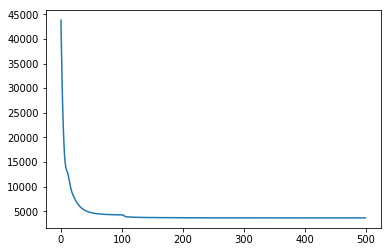

In [17]:
hres_dim = (1, 180, 240, 38)
res_config = config(hres_dim, shape_mode = 0, init_mode = 1)
res_ph = place_holder(res_config)

hres_tensor = init_hres(res_config, lres_gt)
lres_tensor = frame_model(res_config, hres_tensor)
evf_tensor = event_model(res_config, hres_tensor)
loss = loss_no_flow(res_config, res_ph, hres_tensor, lres_tensor, evf_tensor)

optimizer = tf.train.AdamOptimizer(learning_rate = res_ph.learning_rate, beta1 = res_config.beta1, beta2 = res_config.beta2)
opt_min = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

iloss = np.empty((res_config.epochs,))
for iepoch in range(res_config.epochs):
    if iepoch == 0:
        res_config.lr = res_config.lr_init
    hres_rec, iloss[iepoch], _ = sess.run([hres_tensor, loss, opt_min],
                               feed_dict={res_ph.lres_gt: lres_gt, 
                                          res_ph.evf_gt: evf_gt, 
                                          res_ph.learning_rate: res_config.lr})
    if iepoch % res_config.lr_update == 0:
        print("Epoch:", iepoch, "learning rate: %5f" % res_config.lr)
        if iepoch > 0:
            res_config.lr *= 0.1
print("hres_rec shape:", np.shape(hres_rec))
print("Max value %0.2f, min value %0.2f" % (np.amax(hres_rec), np.amin(hres_rec)))
plt.plot(range(res_config.epochs), iloss)
plt.show()

Text(0.5, 1.0, 'f10-f9')

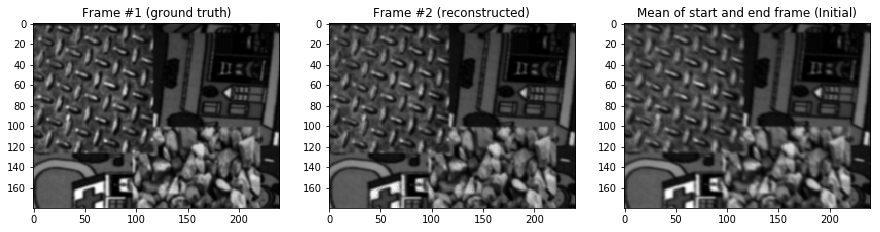

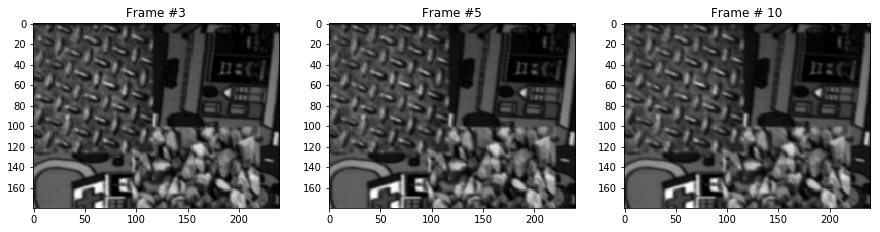

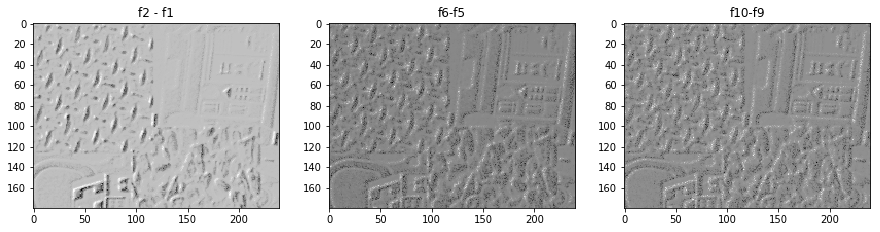

In [18]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(hres_rec[0,:,:,0], cmap = 'gray')
plt.title("Frame #1 (ground truth)")
plt.subplot(132)
plt.imshow(hres_rec[0,:,:,1], cmap = 'gray')
plt.title("Frame #2 (reconstructed)")
plt.subplot(133)
plt.imshow(np.squeeze(np.mean(lres_gt, 3)), cmap = 'gray')
plt.title("Mean of start and end frame (Initial)")

plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(hres_rec[0,:,:,2], cmap = 'gray')
plt.title("Frame #3")
plt.subplot(132)
plt.imshow(hres_rec[0,:,:,4], cmap = 'gray')
plt.title("Frame #5")
plt.subplot(133)
plt.imshow(hres_rec[0,:,:,9], cmap = 'gray')
plt.title("Frame # 10")

plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(hres_rec[0,:,:,1] - hres_rec[0,:,:,0], cmap = 'gray')
plt.title("f2 - f1")
plt.subplot(132)
plt.imshow(hres_rec[0,:,:,5] - hres_rec[0,:,:,4], cmap = 'gray')
plt.title("f6-f5")
plt.subplot(133)
plt.imshow(hres_rec[0,:,:,9] - hres_rec[0,:,:,8], cmap = 'gray')
plt.title("f10-f9")

In [22]:
savePath = 'results/mbr-interp-1-evf/simulation_3planes'
if not os.path.isdir(savePath):
    os.mkdir(savePath)
    os.mkdir(os.path.join(savePath, 'reconstruction'))
    os.mkdir(os.path.join(savePath, 'ground_truth'))
    
# save ground truth images
## save low-res images
if not os.path.exists(os.path.join(savePath, 'ground_truth', 'low-res-1.png')):
    imsave(os.path.join(savePath, 'ground_truth', 'low-res-1.png'), lres_gt[0,:,:,0])
    imsave(os.path.join(savePath, 'ground_truth', 'low-res-2.png'), lres_gt[0,:,:,1])
if not os.path.exists(os.path.join(savePath, 'ground_truth', 'evf-1.png')):
    evf2img = vs.evfToFloatImg(evf_gt)
    imsave(os.path.join(savePath, 'ground_truth', 'evf-1.png'), evf2img[:,:,0])
if not os.path.exists(os.path.join(savePath, 'reconstruction', 'high-res*')):
    for i in range(np.size(hres_rec, 3)):
        filestring = 'high-res-%d.png' % (i+1)
        imsave(os.path.join(savePath, 'reconstruction', filestring), vs.imgNonNeg(hres_rec[0,:,:,i]))

if os.path.exists(os.path.join(savePath, 'params.txt')):
    os.remove(os.path.join(savePath, 'params.txt'))
with open(os.path.join(savePath, 'params.txt'), 'w') as f:
    saveConfig = {'shape_mode': res_config.shape_mode, 'init_mode': res_config.init_mode,
                 'noise_a': res_config.noise_a, 'ev_weight': res_config.ev_weight,
                  'tanh_coef': res_config.tanh_coef, 'tv_coef_xy': res_config.tv_coef_xy,
                 'tv_coef_t': res_config.tv_coef_t, 'lr': res_config.lr_init, 'lr_update': res_config.lr_update,
                  'epochs': res_config.epochs}
    json.dump(saveConfig, f)
